In [1]:
!pip install librosa matplotlib numpy tensorflow scikit-learn

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 3.4 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.8 MB 2.4 MB/s eta 0:00:01
   ------------------ --------------------- 1.3/2.8 MB 2.4 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 2.1 MB/s eta 0:00:01
   --------------------------------- ------ 2.4/2.8 MB 2.2 MB/s eta 0:00:01
   ------------------------------------- -- 2.6/2.8 MB 2.3 MB/s eta 0:00:01
   ------------------------------------- -- 2.6/2.8 MB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ------------------------------ --------- 0.8/1.0 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   - ---------------------------

Epoch 1/20


C:\Users\vinol\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.0928 - loss: 391.0260 - val_accuracy: 0.1050 - val_loss: 2.3026
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.1024 - loss: 2.2986 - val_accuracy: 0.1050 - val_loss: 2.3029
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.1044 - loss: 2.3023 - val_accuracy: 0.0750 - val_loss: 2.3034
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.0869 - loss: 2.3025 - val_accuracy: 0.0750 - val_loss: 2.3037
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.1075 - loss: 2.3025 - val_accuracy: 0.0650 - val_loss: 2.3045
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.1115 - loss: 2.3014 - val_accuracy: 0.0650 - val_loss: 2.3055
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.0856 - loss: 2.3004 - val_accuracy: 0.0650 - val_loss: 2.3060
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.0738 - loss: 2.3051 - val_accuracy: 0.0650 - va

C:\Users\vinol\AppData\Local\Temp\ipykernel_3200\2651034543.py:110: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\vinol\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


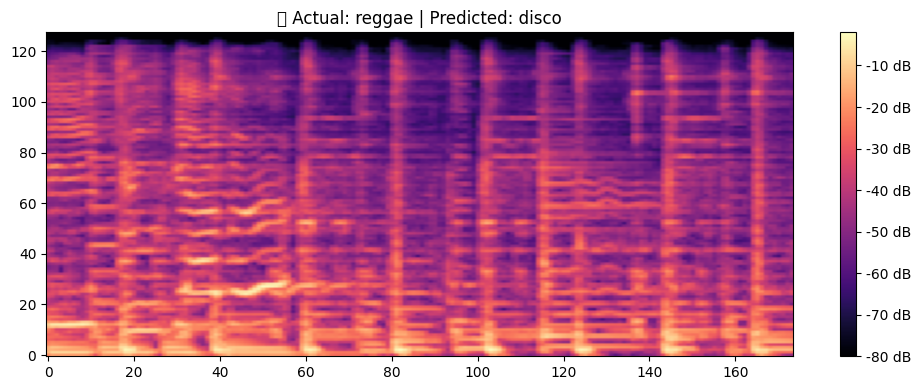

In [7]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


def extract_features(file_path, max_pad_len=174):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        
        
        if log_mel_spec.shape[1] < max_pad_len:
            pad_width = max_pad_len - log_mel_spec.shape[1]
            log_mel_spec = np.pad(log_mel_spec, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            log_mel_spec = log_mel_spec[:, :max_pad_len]
        
        return log_mel_spec
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


def load_dataset(dataset_path='genres'):
    features = []
    labels = []
    
    genres = os.listdir(dataset_path)
    for genre in genres:
        genre_folder = os.path.join(dataset_path, genre)
        if not os.path.isdir(genre_folder):
            continue
        
        for file in os.listdir(genre_folder):
            if file.lower().endswith(('.wav', '.au')):  # <-- Support both formats
                file_path = os.path.join(genre_folder, file)
                feature = extract_features(file_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(genre)

    return np.array(features), np.array(labels)


X, y = load_dataset('genres')

X = X.reshape(X.shape[0], 128, 174, 1)
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 174, 1)),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


test_loss, test_acc = model.evaluate(X_test, y_test)
print("\n🎯 Test Accuracy: {:.2f}%".format(test_acc * 100))

import random


genre_labels = le.classes_

print("\n📊 Predictions on random test samples:")
for _ in range(5):
    idx = random.randint(0, len(X_test) - 1)
    sample = X_test[idx].reshape(1, 128, 174, 1)
    prediction = model.predict(sample)
    predicted_label = genre_labels[np.argmax(prediction)]
    actual_label = genre_labels[np.argmax(y_test[idx])]
    
    print(f"🔹 Actual: {actual_label.ljust(10)} | Predicted: {predicted_label}")


import matplotlib.pyplot as plt

idx = random.randint(0, len(X_test) - 1)
plt.figure(figsize=(10, 4))
plt.title(f"🎵 Actual: {genre_labels[np.argmax(y_test[idx])]} | Predicted: {genre_labels[np.argmax(model.predict(X_test[idx].reshape(1, 128, 174, 1)))]}")
plt.imshow(X_test[idx].squeeze(), aspect='auto', origin='lower', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()
